In [ ]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# Covid-19 SG dataset details

sheet_id = "1gFTNs_GtnTIyyVWXmsQxwdZpGbyicZM2HJcXvCf4b3k"
sheet_name = "Sheet1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

# read Covid-19 SG dataset
sg_data = pd.read_csv(url)
sg_data_filtered = sg_data.iloc[:, :30]

,Date,Daily Confirmed,False Positives Found,Cumulative Confirmed,Daily Discharged,Passed but not due to COVID,Cumulative Discharged,Discharged to Isolation,Still Hospitalised,Daily Deaths,Cumulative Deaths,Tested positive demise,Daily Imported,Daily Local transmission,Local cases residing in dorms MOH report,Local cases not residing in doms MOH report,Intensive Care Unit (ICU),General Wards MOH report,In Isolation MOH report,Total Completed Isolation MOH report,Total Hospital Discharged MOH report,Requires Oxygen Supplementation,Linked community cases,Unlinked community cases,Phase,Cumulative Vaccine Doses,Cumulative Individuals Vaccinated,Cumulative Individuals Vaccination Completed,Perc population completed at least one dose,Perc population completed vaccination
623,2021-10-07,3483,0.0,116864,3445,0,92577,22639,1504,3,136,0,8,3475,692.0,2783.0,40,1494.0,22639.0,85647.0,6908.0,297.0,NaN,NaN,Stabilisation Phase,9355632.0,4595270.0,4532399.0,85%,83%
624,2021-10-08,3590,0.0,120454,2454,0,95031,23739,1534,6,142,0,0,3590,765.0,2825.0,41,1523.0,23739.0,87951.0,7058.0,307.0,NaN,NaN,Stabilisation Phase,9374827.0,4597008.0,4534827.0,85%,83%
625,2021-10-09,3703,0.0,124157,3019,0,98050,24407,1539,11,153,0,3,3700,832.0,2868.0,40,1529.0,24407.0,90831.0,7197.0,302.0,NaN,NaN,Stabilisation Phase,9401855.0,4599302.0,4538549.0,85%,83%
626,2021-10-10,2809,0.0,126966,2469,0,100519,24694,1583,9,162,0,2,2807,631.0,2176.0,41,1572.0,24694.0,93200.0,7297.0,292.0,NaN,NaN,Stabilisation Phase,9426896.0,4601688.0,4541733.0,85%,83%
627,2021-10-11,2263,0.0,129229,2249,0,102768,24613,1668,10,172,0,8,2255,306.0,1949.0,42,1656.0,24613.0,95329.0,7417.0,308.0,NaN,NaN,Stabilisation Phase,9457764.0,4603882.0,4543625.0,85%,83%


# EDA & Pre-processing

In [13]:
sg_data_filtered.tail()

,Date,Daily Confirmed,False Positives Found,Cumulative Confirmed,Daily Discharged,Passed but not due to COVID,Cumulative Discharged,Discharged to Isolation,Still Hospitalised,Daily Deaths,Cumulative Deaths,Tested positive demise,Daily Imported,Daily Local transmission,Local cases residing in dorms MOH report,Local cases not residing in doms MOH report,Intensive Care Unit (ICU),General Wards MOH report,In Isolation MOH report,Total Completed Isolation MOH report,Total Hospital Discharged MOH report,Requires Oxygen Supplementation,Linked community cases,Unlinked community cases,Phase,Cumulative Vaccine Doses,Cumulative Individuals Vaccinated,Cumulative Individuals Vaccination Completed,Perc population completed at least one dose,Perc population completed vaccination
623,2021-10-07,3483,0.0,116864,3445,0,92577,22639,1504,3,136,0,8,3475,692.0,2783.0,40,1494.0,22639.0,85647.0,6908.0,297.0,NaN,NaN,Stabilisation Phase,9355632.0,4595270.0,4532399.0,85%,83%
624,2021-10-08,3590,0.0,120454,2454,0,95031,23739,1534,6,142,0,0,3590,765.0,2825.0,41,1523.0,23739.0,87951.0,7058.0,307.0,NaN,NaN,Stabilisation Phase,9374827.0,4597008.0,4534827.0,85%,83%
625,2021-10-09,3703,0.0,124157,3019,0,98050,24407,1539,11,153,0,3,3700,832.0,2868.0,40,1529.0,24407.0,90831.0,7197.0,302.0,NaN,NaN,Stabilisation Phase,9401855.0,4599302.0,4538549.0,85%,83%
626,2021-10-10,2809,0.0,126966,2469,0,100519,24694,1583,9,162,0,2,2807,631.0,2176.0,41,1572.0,24694.0,93200.0,7297.0,292.0,NaN,NaN,Stabilisation Phase,9426896.0,4601688.0,4541733.0,85%,83%
627,2021-10-11,2263,0.0,129229,2249,0,102768,24613,1668,10,172,0,8,2255,306.0,1949.0,42,1656.0,24613.0,95329.0,7417.0,308.0,NaN,NaN,Stabilisation Phase,9457764.0,4603882.0,4543625.0,85%,83%


In [14]:
sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 30 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Date                                          628 non-null    object 
 1   Daily Confirmed                               628 non-null    int64  
 2   False Positives Found                         519 non-null    float64
 3   Cumulative Confirmed                          628 non-null    int64  
 4   Daily Discharged                              628 non-null    int64  
 5   Passed but not due to COVID                   628 non-null    int64  
 6   Cumulative Discharged                         628 non-null    int64  
 7   Discharged to Isolation                       628 non-null    int64  
 8   Still Hospitalised                            628 non-null    int64  
 9   Daily Deaths                                  628 non-null    int

In [15]:
# convert date to columns: year, month, day before dropping date column

sg_data_filtered["Date"] = pd.to_datetime(sg_data_filtered["Date"])
sg_data_filtered["Year"] = sg_data_filtered["Date"].dt.year
sg_data_filtered["Month"] = sg_data_filtered["Date"].dt.month
sg_data_filtered["Day"] = sg_data_filtered["Date"].dt.day
sg_data_filtered.drop("Date", axis=1, inplace=True)

In [16]:
# convert NaN values for phase to None

sg_data_filtered["Phase"] = sg_data_filtered["Phase"].fillna("None")

In [17]:
# change to one-hot dummy for phase

sg_data_filtered = pd.concat([sg_data_filtered, pd.get_dummies(sg_data_filtered['Phase'], prefix = 'Phase_=')], axis = 1).drop('Phase', axis = 1)

In [18]:
# convert percentage for Perc population completed at least one dose & Perc population completed vaccination

sg_data_filtered["Perc population completed at least one dose"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed at least one dose"]]
sg_data_filtered["Perc population completed vaccination"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed vaccination"]]

In [19]:
# convert all NaN values present to zeros for the rest of the columns (if data is unavailable, just treat as 0)

sg_data_filtered.fillna(0, inplace=True)

In [20]:
# check to see if NaN values still present

sg_data_filtered.isnull().values.any()

False

In [21]:
# check column info after pre-processing

sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 40 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Daily Confirmed                               628 non-null    int64  
 1   False Positives Found                         628 non-null    float64
 2   Cumulative Confirmed                          628 non-null    int64  
 3   Daily Discharged                              628 non-null    int64  
 4   Passed but not due to COVID                   628 non-null    int64  
 5   Cumulative Discharged                         628 non-null    int64  
 6   Discharged to Isolation                       628 non-null    int64  
 7   Still Hospitalised                            628 non-null    int64  
 8   Daily Deaths                                  628 non-null    int64  
 9   Cumulative Deaths                             628 non-null    int

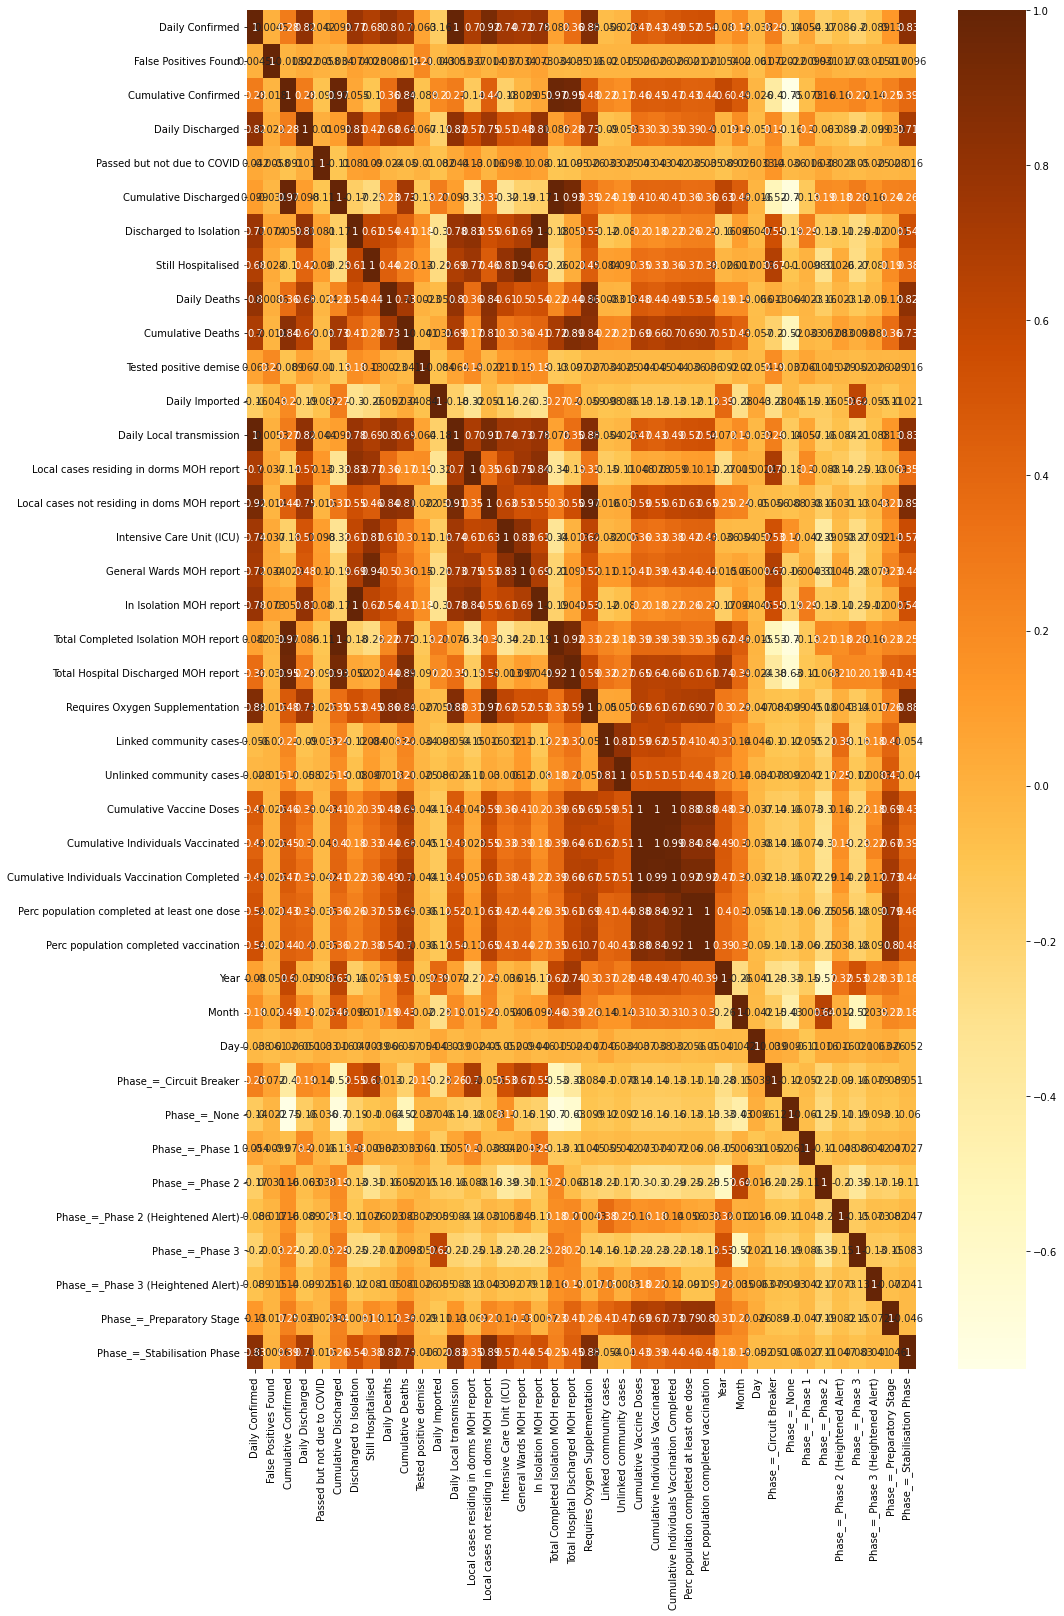

In [22]:
# corr. heatmap

plt.figure(figsize=(15,25))
sns.heatmap(sg_data_filtered.corr(), cmap='YlOrBr', annot=True)

In [23]:
sg_data_filtered.corr()["Requires Oxygen Supplementation"].sort_values(ascending=False)

Requires Oxygen Supplementation                 1.000000
Local cases not residing in doms MOH report     0.974791
Phase_=_Stabilisation Phase                     0.884483
Daily Confirmed                                 0.878253
Daily Local transmission                        0.876519
Daily Deaths                                    0.857378
Cumulative Deaths                               0.841393
Daily Discharged                                0.730896
Perc population completed vaccination           0.703519
Perc population completed at least one dose     0.691307
Cumulative Individuals Vaccination Completed    0.670993
Cumulative Vaccine Doses                        0.652149
Intensive Care Unit (ICU)                       0.620784
Cumulative Individuals Vaccinated               0.611875
Total Hospital Discharged MOH report            0.594590
Discharged to Isolation                         0.532521
In Isolation MOH report                         0.531270
General Wards MOH report       

# Train Test Split

In [26]:
# change y variable accordingly to what is of interest

X = sg_data_filtered.drop("Requires Oxygen Supplementation", axis=1)
y = sg_data_filtered["Requires Oxygen Supplementation"]

In [27]:
# split using 25% for test as amount of data isn't much so that we've got more points to test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Linear regression

In [28]:
# build multiple linear regression model

regression = LinearRegression()
regression.fit(X_train, y_train)
pred = regression.predict(X_test)

In [29]:
# assessing model

train_adjusted_r2 = 1 - (1-regression.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-regression.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for LR")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
print(f"R-squared score for train: {regression.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {regression.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")

Evaluation Metrics for LR
MAE: 3.271896067724243
MSE: 29.706234850811523
RMSE: 5.450342636092847
R-squared score for train: 0.9923437945802249
Adjusted R-squared score for train: 0.9918359850370766
R-squared score for test: 0.9836389440007117
Adjusted R-squared score for test: 0.9825537719191263


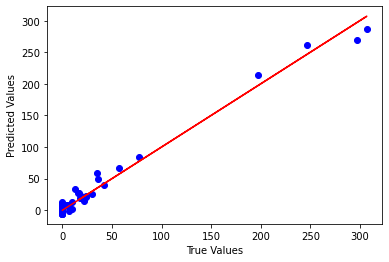

In [30]:
# For test set

# scatter for predictions
plt.scatter(y_test, pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

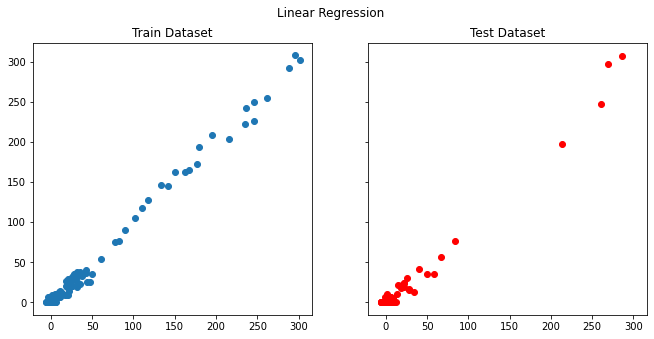

In [31]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(regression.predict(X_train), y_train)
ax[1].scatter(pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Linear Regression')

plt.show()

In [32]:
# find out feature importance

regr_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': regression.coef_
})

regr_importance = regr_importance.sort_values(by='Importance', ascending=False)
regr_importance

,Attribute,Importance
25,Perc population completed at least one dose,689.514564
31,Phase_=_None,6.856703
36,Phase_=_Phase 3 (Heightened Alert),6.073583
37,Phase_=_Preparatory Stage,5.229941
34,Phase_=_Phase 2 (Heightened Alert),2.466141
8,Daily Deaths,2.311479
33,Phase_=_Phase 2,1.762865
7,Still Hospitalised,0.606286
6,Discharged to Isolation,0.603173
5,Cumulative Discharged,0.497164


# Lasso Regression

In [33]:
# build lasso model

lasso = Lasso(max_iter=10000)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12802.898132680633, tolerance: 86.20636942675158
  positive)


In [34]:
# assessing model

train_adjusted_r2 = 1 - (1-lasso.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-lasso.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Lasso")
print(f"MAE: {mean_absolute_error(y_test, lasso_pred)}")
print(f"MSE: {mean_squared_error(y_test, lasso_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, lasso_pred))}")
print(f"R-squared score for train: {lasso.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {lasso.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")

Evaluation Metrics for Lasso
MAE: 4.352382815431413
MSE: 64.0368380765741
RMSE: 8.002302048571655
R-squared score for train: 0.9735676431561678
Adjusted R-squared score for train: 0.9718144766308117
R-squared score for test: 0.9647309630772825
Adjusted R-squared score for test: 0.9623916902201635


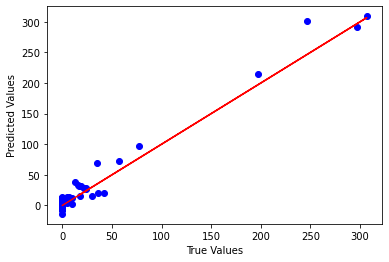

In [35]:
# For test set

# scatter for predictions
plt.scatter(y_test, lasso_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

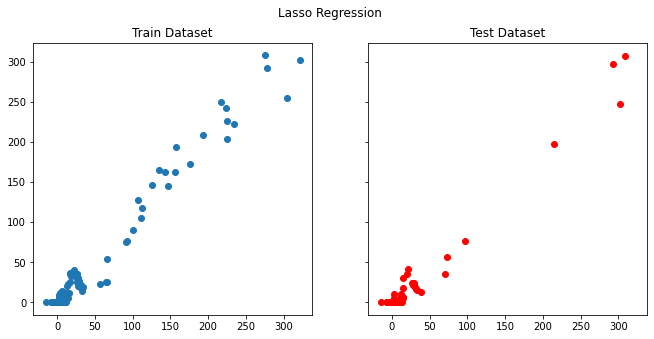

In [36]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(lasso.predict(X_train), y_train)
ax[1].scatter(lasso_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Lasso Regression')

plt.show()

In [37]:
# find out feature importance

lasso_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': lasso.coef_
})

lasso_importance = lasso_importance.sort_values(by='Importance', ascending=False)
lasso_importance

,Attribute,Importance
8,Daily Deaths,1.587721
15,Intensive Care Unit (ICU),0.521674
9,Cumulative Deaths,0.407587
29,Day,0.057202
14,Local cases not residing in doms MOH report,0.046301
0,Daily Confirmed,0.028241
7,Still Hospitalised,0.009970
6,Discharged to Isolation,0.004421
12,Daily Local transmission,0.000877
2,Cumulative Confirmed,0.000727
